In [2]:
# Import the necessary libraries.
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

import numpy as np
import matplotlib.pyplot as plt
import gym
from matplotlib.animation import FuncAnimation
from IPython import display #.display import clear_output

# RSA Workshop: Reinforcement Learning

In this workshop, you will get to learn about the basics of reinforcement learning. Reinforcement learning is one of the three main methods of teaching an intelligent agent to control a specific system given the environment surrounding this system. This practicum is structured as follows. First, we recap the background knowledge that you have learned during the first half of the workshop. Afterwards.

## 1. Background

Before we dive into Reinforcement learning, we first need to understand its derivation of a simple model called Markov Decision Process (MDP), also called as **observe-act-loop**. MDP describes how a single agent should choose an action $a$ to perform given the current state $s$ in order to go the next (desired) state $s'$ such that it maximizes the reward acquisition.

### 1.1 Transition Model

Going to the next state $s'$ given the current state $s$ and the action taken $a$ is called a **transition** $T$. This can be formulated as:

$$
T(s'\mid s,a) = P(s'\mid s, a),
$$

where $P(\cdot)$ is a probability distribution.

### 1.2 Rewards

In order for the intelligent agent to actually learn how to find the optimal solution, we give it **rewards**. Rewards are always collected as numbers and the agent's goal is to *maximize* its accumulation of rewards. An agent therefore receives a reward $r$ based on the **outcome** of a transition $T$.

In addition, given that the reward $r$ is a number, it can also be negative. A negative reward is called a **penalty** and the agent aims to *minimize* this cost rather than *maximize*.This can be used penalize the agent if it does something undesirable.

### 1.3 Policy

How does an agent choose an action $a$ to go from the current state $s$ to the next state $s'$? We therefore give it a policy $\pi$ that maximizes the utility $U$.

$$
U^* = \underset{\pi}{\max}\mathbb{E}_\pi\left[\sum_{t=1}^T r_t\gamma^{t-1}\right],
$$

where $t$ is time, $T$ is the time horizon, $r_t$ is the reward $r$ at a given time instant $t$, and $\gamma$ is the discount factor.

Utility $U$ is the expected sum of rewards for the time horizon $T\ge1$.

You may ask yourself, if the time horizon $T$ goes towards infinity, wouldn't the utility $U$ blow up into infinity as well? That is correct. This issue can be avoided by using the discount factor $\gamma$ which allows the utility to converge to a value. Discount factor $\gamma$ should always have a value between zero and (not including) one. Therefore:

$$
\gamma \in (0,1)
$$


In [3]:
"""
Create an OpenAI gym environment called CartPole-v1.
"""
env = gym.make('CartPole-v1', render_mode="rgb_array")

# Display the action space and observation space.
print("Action space: ", env.action_space)
print("Observation space: ", env.observation_space)

Action space:  Discrete(2)
Observation space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


The action space $\mathcal{A}$ has a shape of $\R^1$ which can only take one of the two values $\{0,1\}$. This means that it is one-dimensional and takes:
- 0 as push the cart to the left.
- 1 as push the cart to the right.

The observation space $\mathcal{S}$ has a shape of $\R^4$. Each dimension is described as follows and in order:
- Cart position $x \in [-4.8, 4.8]$.
- Cart velocity $\dot x \in (-\infty,\infty)$.
- Pole angle $\theta \in [-0.418, 0.418]$ rad, or $[-24^\circ,24^\circ]$.
- Pole angular velocity $\dot\theta\in(-\infty,\infty)$.

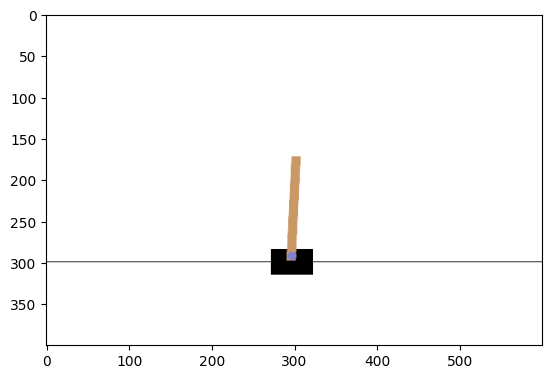

In [4]:
# Initialize a starting state s.
s = env.reset()

# Display the initial state s0.
s0 = env.render()
plt.imshow(s0)

In [35]:
dt = 0.1    # time step in s
T = 10      # maximum time.

t = int(T / dt)
frames = [s0]
actions = []
for _ in range(t):

    # Take a random action a of the action space A.
    a = env.action_space.sample()

    # Perform action a and obtain new state s', reward r,
    # and termination boolean done.
    s, r, done, _, _ = env.step(action=a)

    # Obtain the image of the current state.
    im = env.render()

    # Create histories by append image into list of observations, and action into list of actions.
    frames.append(im)
    actions.append(a)


In [37]:
fig = plt.figure()

im = plt.imshow(frames[0], animated=True)

def animate(frame_number):
    im.set_array(frames[frame_number])
    plt.title("Cartpole with random actions")
    return im

anim = FuncAnimation(fig, animate, frames=len(frames), interval=40)
display.display(display.HTML(anim.to_html5_video()))
plt.close()

Number of states:  4
Number of actions:  2


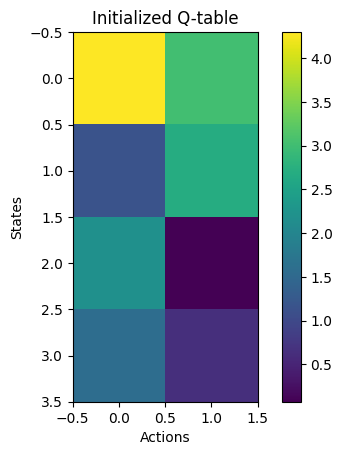

In [29]:
n_state = env.observation_space.shape[0]    # Number of states
n_action = env.action_space.n               # Number of actions

# Initalize Q-table for every actions for each state.
""" YOUR CODE HERE """
Q = np.random.uniform(low=0, high=5, size=(n_state, n_action))
""" END CODE """

# Display the Q-table.
print("Number of states: ", n_state)
print("Number of actions: ", n_action)
plt.figure()
plt.imshow(Q)
plt.colorbar()
plt.xlabel("Actions")
plt.ylabel("States")
plt.title("Initialized Q-table")
plt.show()

$$
a=\begin{cases}
    \underset{a'}{\arg\max}Q(s,a'),\qquad P(0\le X\le1)\gt\epsilon\\
    \text{some random action},\;P(0\le X\le1)\le\epsilon
\end{cases}
$$

In [30]:
# 
def evaluate_policy(Q, s, epsilon):
    """
    Parameters:
    - Q: some Q-table.
    - s: current state of the environment.
    - epsilon: the probability to explore.
    
    Return:
    - a: action to take based on policy.
    """
    a = -1

    """ YOUR CODE HERE """
    x = np.random.uniform(low=0, high=1, size=())
    if x > epsilon:
        a = np.argmax(Q[s])
    else:
        a = np.random.randint(low=0, high=2)
    """ END CODE """

    assert a in [0,1], "Action a is not of valid set {0,1}."
    return a

$$
Q(s_k,a_k)\larr Q(s_k,a_k)+\alpha_k[\underbrace{r_{k+1}+\gamma\underset{a'}{\max}Q(s_{k+1},a') - Q(s_k,a_k)}_{\text{Temporal difference}}]
$$

In [31]:
def update_Q(Q, s, a, r, s_next, alpha, gamma):
    """
    Update the Q-table with a new value for entry (s,a)
    given the maximum expected future reward at (s_next, a_prime).
    Parameters:
    - Q: some Q-table.
    - s: current state of the environment.
    - a: best action to take at the current state s.
    - s_next: consequent state by taking action a at current state s.
    - alpha: the learning rate.
    - gamma: the discount factor.
    
    Returns:
    - Q: the updated Q-table.
    """
    q = Q[s,a]
    temp_diff = gamma * np.argmax(Q[s_next]) - q
    Q[s,a] = q + alpha * temp_diff

    assert Q.shape == (n_state, n_state), \
        "Updated Q-table does not have the correct shape."
    return Q
    